In [3]:
%load_ext rpy2.ipython

In [4]:
%%R
workDir = '/home/chantal/Chazy/Bulk/ITS/data/'
figDir = '/home/chantal/Chazy/Bulk/ITS/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/ITS/'
physeqBulk = 'bulk-core'


nprocs = 20

In [5]:
%%R
library(phyloseq)
library(tidyr)
library(plyr); library(dplyr)
library(DESeq2)
library(foreach)
library(doParallel)
library(ggplot2)
library(gridExtra)
library(reshape2)
library(RColorBrewer)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/f

#### Read in sample metadata and OTU table

In [4]:
%%R

F = file.path(physeqDir, physeqBulk)
print(F)
physeq.Bulk = readRDS(F)
physeq.Bulk.m = physeq.Bulk %>% sample_data
physeq.Bulk = prune_samples((physeq.Bulk.m$Land_Management != "PAS" & !(is.na(physeq.Bulk.m$Soil_Moisture))),
                           physeq.Bulk)
physeq.Bulk.m = physeq.Bulk %>% sample_data


physeq.Bulk = prune_samples((physeq.Bulk.m$Soil_Moisture != 50),
                           physeq.Bulk)

physeq.Bulk = subset_taxa(physeq.Bulk, Rank1=="k__Fungi")

physeq.Bulk.m = physeq.Bulk %>% sample_data


physeq.Bulk

[1] "/home/chantal/Chazy/data/phyloseq/ITS//bulk-core"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2247 taxa and 157 samples ]
sample_data() Sample Data:       [ 157 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2247 taxa by 7 taxonomic ranks ]


In [5]:
%%R
get_l2fc = function(physeq.obj, Land_Management, sparsity_threshold) {
  
    physeq.Bulk.m = physeq.obj %>% sample_data

    p = prune_samples((physeq.Bulk.m$Land_Management == Land_Management),
                           physeq.Bulk)
   
    
    p = filter_taxa(p, function(x) sum(x > 0) > sparsity_threshold * length(x), TRUE)
 
    dds = phyloseq_to_deseq2(p, ~ Soil_Moisture)
    dds = DESeq(dds, quiet = TRUE, fitType = "local")
        
    theta = 1
    r = results(dds, independentFiltering = FALSE)
    r$OTU = rownames(r)
   
    d = data.frame(r[, c("OTU","log2FoldChange", "lfcSE", "padj")])

   # d$padj = p.adjust(p, method = "BH")
    TT = data.frame(tax_table(p))
    TT$OTU = rownames(TT)
    d = left_join(d, TT)


    d
}
                    
                  

In [6]:
%%R

sdm = physeq.Bulk %>% sample_data %>% 
    filter(! is.na(Till)) %>%
    select(Land_Management) %>%
   distinct() %>%
    arrange(Land_Management) 
  

sdm

  Land_Management
1             NTH
2             NTR
3             PTH
4             PTR


In [7]:
%%R
# adding range of sparsity thresholds (all pairwise)
sdms = sdm %>%
    unite(sdm, Land_Management, sep='___')

sdms = expand.grid(sdms$sdm,
                    sparsity_threshold = seq(0.05,0.95,0.05)) %>%
    separate(Var1, c('Land_Management'), sep='___')


cat('Number of pairwise combinations of variables:', sdms %>% nrow, '\n\n')
head(sdms) 

Number of pairwise combinations of variables: 76 

  Land_Management sparsity_threshold
1             NTH               0.05
2             NTR               0.05
3             PTH               0.05
4             PTR               0.05
5             NTH               0.10
6             NTR               0.10


In [8]:
%%R
registerDoParallel(8)

df.l2fc = tbl_df(mdply(sdms, 
                       get_l2fc, 
                       .parallel = TRUE, 
                       physeq.obj = physeq.Bulk))
df.l2fc

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:1

Source: local data frame [15,433 x 13]

   Land_Management sparsity_threshold       OTU log2FoldChange     lfcSE
             (chr)              (dbl)     (chr)          (dbl)     (dbl)
1              NTH               0.05  OTU.6089    0.125927940 0.1586358
2              NTH               0.05 OTU.14908    0.259555677 0.1734089
3              NTH               0.05  OTU.6041   -0.080342430 0.1699859
4              NTH               0.05  OTU.6291    0.120252994 0.1580007
5              NTH               0.05  OTU.9364   -0.004118337 0.1693170
6              NTH               0.05   OTU.586   -0.281597234 0.1395269
7              NTH               0.05  OTU.1470    0.088483217 0.1120726
8              NTH               0.05  OTU.5914    0.006953563 0.1370819
9              NTH               0.05 OTU.24728   -0.232457666 0.1755208
10             NTH               0.05  OTU.3084    0.042118115 0.1592230
..             ...                ...       ...            ...       ...
Variables n

In [9]:
%%R
summarise(df.l2fc,
  meanl2fc = mean(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

     meanl2fc
        (dbl)
1 -0.04603964


In [10]:
%%R
summarise(df.l2fc,
  sdl2fc = sd(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

     sdl2fc
      (dbl)
1 0.1704594


In [11]:
%%R
df.l2fc$padj2 = p.adjust(df.l2fc$padj, method = "BH")

In [12]:
%%R
df.l2fc$Moisture[df.l2fc$log2FoldChange > 0] = "increasing"
df.l2fc$Moisture[df.l2fc$log2FoldChange <0] = "decreasing"

In [13]:
%%R
write.table(df.l2fc, "data/l2fc_MoistCompiled_allsamp", row.names = FALSE, sep = ",")

In [14]:
%%R
df.l2fc = read.table('data/l2fc_MoistCompiled_allsamp', sep =',', header = TRUE)

In [15]:
%%R
head(df.l2fc)

  Land_Management sparsity_threshold       OTU log2FoldChange     lfcSE
1             NTH               0.05  OTU.6089    0.125927940 0.1586358
2             NTH               0.05 OTU.14908    0.259555677 0.1734089
3             NTH               0.05  OTU.6041   -0.080342430 0.1699859
4             NTH               0.05  OTU.6291    0.120252994 0.1580007
5             NTH               0.05  OTU.9364   -0.004118337 0.1693170
6             NTH               0.05   OTU.586   -0.281597234 0.1395269
       padj    Rank1            Rank2              Rank3           Rank4
1 0.8696062 k__Fungi  p__unidentified    c__unidentified o__unidentified
2 0.5864702 k__Fungi p__Basidiomycota  c__Agaricomycetes   o__Agaricales
3 0.9278056 k__Fungi p__Basidiomycota  c__Agaricomycetes   o__Agaricales
4 0.8696997 k__Fungi p__Basidiomycota  c__Agaricomycetes   o__Agaricales
5 0.9930422 k__Fungi p__Basidiomycota  c__Agaricomycetes    o__Boletales
6 0.3626986 k__Fungi    p__Ascomycota c__Dothideomycetes  

In [16]:
%%R
r = filter(df.l2fc, padj2 <=0.10)
print(length(unique(r$OTU)))
print(length(df.l2fc$OTU))

[1] 24
[1] 15433


In [17]:
%%R

padj.cutoff = 0.10

df.l2fc.rejH.s = df.l2fc %>%
    filter(padj2 < padj.cutoff) %>%
    group_by(sparsity_threshold, Land_Management) %>%
    summarize(n_reject_hypo = n()) %>%
    ungroup

df.l2fc.rejH.s %>%  head

Source: local data frame [6 x 3]

  sparsity_threshold Land_Management n_reject_hypo
               (dbl)          (fctr)         (int)
1               0.05             NTH             6
2               0.05             NTR             5
3               0.05             PTH             1
4               0.05             PTR             2
5               0.10             NTH             7
6               0.10             NTR             4


In [18]:
%%R
# max number of rejected hypos 
max.rejH = df.l2fc.rejH.s %>%
    arrange(desc(n_reject_hypo)) %>%
    head(n=1)
max.rejH = max.rejH$sparsity_threshold
max.rejH

[1] 0.45


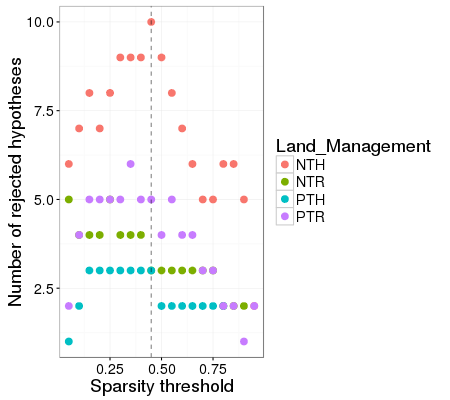

In [19]:
%%R -w 450 -h 400

ggplot(df.l2fc.rejH.s, aes(sparsity_threshold, n_reject_hypo, color = Land_Management)) +
    geom_point(size=3) +
    geom_vline(xintercept=max.rejH, linetype='dashed', alpha=0.5) +
    labs(x='Sparsity threshold', y='Number of rejected hypotheses') +
    theme_bw() +
    theme(
        text = element_text(size=18),
        axis.title.y = element_text(vjust=1)
        )

In [20]:
%%R
df.l2fc.f = df.l2fc %>%
    filter(sparsity_threshold == max.rejH) 

df.l2fc.f %>% nrow

[1] 644


In [21]:
%%R
length(unique(df.l2fc$OTU))

[1] 1108


In [22]:
%%R #-i workDir
# Writing out l2fc table

outFile = 'data/l2fc_ Moist_allSamples.txt'
write.table(df.l2fc.f, 'data/l2fc_Moist_allSamples.txt', sep='\t', quote=FALSE, row.names=FALSE)

In [6]:
%%R
df.l2fc = read.table('data/l2fc_Moist_allSamples.txt', sep='\t', header = TRUE)

In [7]:
%%R
df.l2fc$Rank2 = gsub("p__", "", df.l2fc$Rank2)
df.l2fc$Rank3 = gsub("c__", "", df.l2fc$Rank3)
df.l2fc$Rank4 = gsub("o__", "", df.l2fc$Rank4)
df.l2fc$Rank5 = gsub("f__", "", df.l2fc$Rank5)
df.l2fc$Rank6 = gsub("g__", "", df.l2fc$Rank6)
df.l2fc$Rank7 = gsub("s__", "", df.l2fc$Rank7)

In [8]:
%%R
print(length(df.l2fc$OTU))
print(length(unique(df.l2fc$OTU)))

[1] 644
[1] 256


In [9]:
%%R
resp = df.l2fc %>% filter(padj2 <=0.10) %>% group_by(Moisture) %>% summarise(resp = n()) 
resp$Temp = NULL
print(resp %>% as.data.frame)



    Moisture resp
1 decreasing   19
2 increasing    2


In [22]:
%%R
resp = df.l2fc %>% filter(padj2 <=0.10, Moisture == 'increasing') 
resp

  Land_Management sparsity_threshold       OTU log2FoldChange      lfcSE
1             PTH               0.45 OTU.42439      0.5883986 0.09194773
2             PTR               0.45  OTU.1310      0.3615294 0.08797720
          padj    Rank1      Rank2           Rank3       Rank4          Rank5
1 2.451058e-08 k__Fungi Ascomycota Sordariomycetes Hypocreales Incertae sedis
2 1.174436e-03 k__Fungi Ascomycota   Leotiomycetes  Helotiales    Helotiaceae
        Rank6                 Rank7        padj2   Moisture
1  Acremonium Acremonium persicinum 2.364198e-05 increasing
2 Neobulgaria                  <NA> 7.038744e-02 increasing


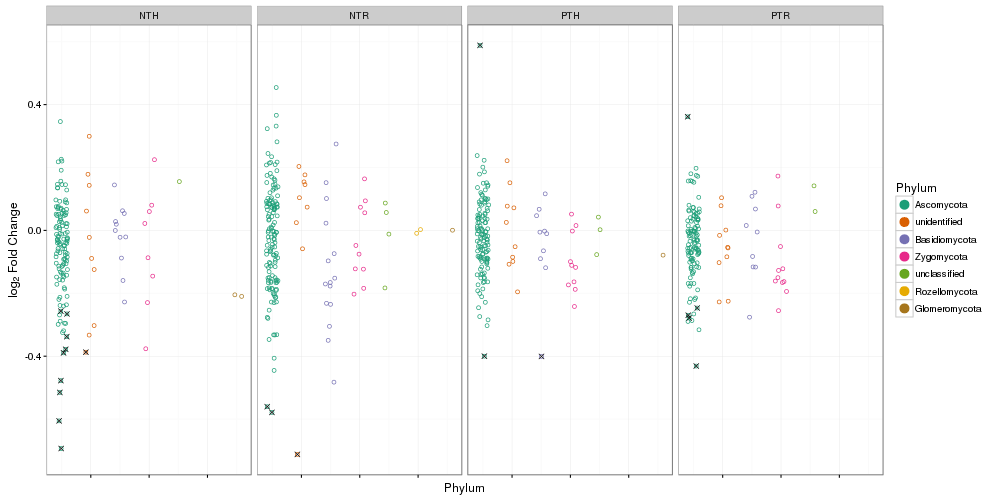

In [11]:
%%R -w 1000 -h 500
d = df.l2fc
FDR = 0.10

d$Rank2 = as.character(d$Rank2)
d$Rank2[is.na(d$Rank2)] = "unclassified"
d$Rank2 = factor(d$Rank2)

max.l2fc = ddply(d, .(Rank2), summarize, M = max(log2FoldChange))
d$Rank2 = factor(d$Rank2, max.l2fc[order(-max.l2fc$M),]$Rank2)

M = max(as.numeric(d$Rank2), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank2)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank2)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, color = Rank2))
p = p + facet_grid(~Land_Management)

p = p + geom_point(alpha = 1.00, shape = 21, size = 1.5)

p = p + scale_color_manual(values = getPalette(colourCount))

p = p + geom_point(data = subset(d, padj2 <= FDR), color = "black", shape = 4, size = 2)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Phylum", color = "Phylum")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4, shape = 19)))

p

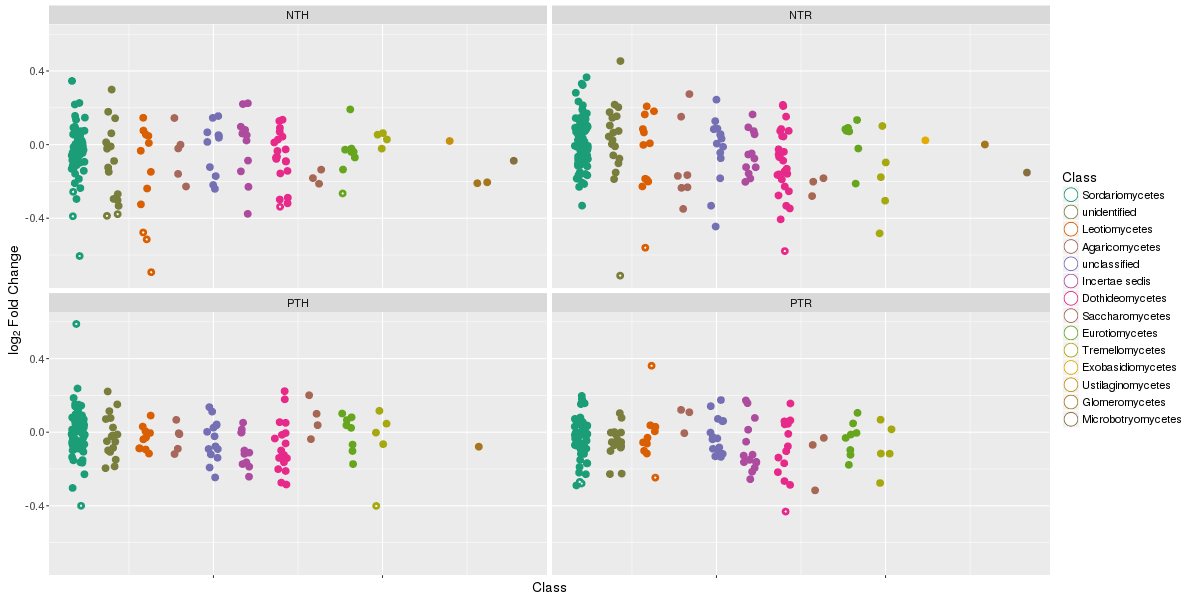

In [12]:
%%R -w 1200 -h 600
d = df.l2fc
FDR = 0.10

d$Rank3 = as.character(d$Rank3)
d$Rank3[is.na(d$Rank3)] = "unclassified"
d$Rank3 = factor(d$Rank3)

max.l2fc = ddply(d, .(Rank3), summarize, M = max(log2FoldChange))
d$Rank3 = factor(d$Rank3, max.l2fc[order(-max.l2fc$M),]$Rank3)

M = max(as.numeric(d$Rank3), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank3)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank3)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, color = Rank3))
p = p + facet_wrap(~Land_Management, ncol = 2)

p = p + geom_point(alpha = 1.00, shape = 19, size = 3)

p = p + scale_color_manual(values = getPalette(colourCount))

p = p + geom_point(data = subset(d, padj2 <= FDR), fill = "white", shape = 21, size = 1)

#p = p + geom_hline(y = 1.3)

#p = p + theme_bw()

p = p + labs(x = "Class", color = "Class")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=6))) +
        theme(text = element_text(size=14), axis.text.x = element_text(angle=90, vjust=1)) 

p = p + theme(axis.text.x = element_blank())



p

In [13]:
%%R
ggsave(filename = "data/figs/OTUs_Moisture.png", plot = p, width =12, height =6)

In [14]:
%%R
r = df.l2fc %>% group_by(OTU, Land_Management) %>% filter(padj2 <=0.10) %>%ungroup %>% arrange(Rank3)
r %>% as.data.frame()

   Land_Management sparsity_threshold       OTU log2FoldChange      lfcSE
1              NTH               0.45   OTU.440     -0.3378090 0.06906928
2              NTR               0.45 OTU.37716     -0.5786605 0.11308301
3              PTR               0.45   OTU.628     -0.4312420 0.08450102
4              NTH               0.45   OTU.134     -0.2654240 0.06469197
5              NTH               0.45   OTU.197     -0.6934511 0.11278416
6              NTH               0.45   OTU.692     -0.5151783 0.10882922
7              NTH               0.45    OTU.70     -0.4775787 0.11941241
8              NTR               0.45   OTU.197     -0.5604553 0.09960125
9              PTR               0.45  OTU.1310      0.3615294 0.08797720
10             PTR               0.45   OTU.525     -0.2467617 0.05731951
11             NTH               0.45   OTU.114     -0.3893399 0.09526148
12             NTH               0.45   OTU.785     -0.6055913 0.11343449
13             NTH               0.45 

In [15]:
%%R
resp = df.l2fc %>% filter(padj2 <=0.10) %>% ungroup %>% group_by(Moisture, Rank3, Land_Management) %>% 
        summarise(resp = n()) %>% arrange(Rank3, resp)
resp %>% as.data.frame

     Moisture           Rank3 Land_Management resp
1  decreasing Dothideomycetes             NTH    1
2  decreasing Dothideomycetes             NTR    1
3  decreasing Dothideomycetes             PTR    1
4  decreasing  Eurotiomycetes             NTH    1
5  decreasing   Leotiomycetes             NTR    1
6  decreasing   Leotiomycetes             PTR    1
7  decreasing   Leotiomycetes             NTH    3
8  decreasing Sordariomycetes             PTH    1
9  decreasing Sordariomycetes             PTR    2
10 decreasing Sordariomycetes             NTH    3
11 decreasing Tremellomycetes             PTH    1
12 decreasing    unidentified             NTR    1
13 decreasing    unidentified             NTH    2
14 increasing   Leotiomycetes             PTR    1
15 increasing Sordariomycetes             PTH    1


In [16]:
%%R
df.l2fc %>% filter(OTU == 'OTU.197')

  Land_Management sparsity_threshold     OTU log2FoldChange      lfcSE
1             NTH               0.45 OTU.197     -0.6934511 0.11278416
2             NTR               0.45 OTU.197     -0.5604553 0.09960125
          padj    Rank1      Rank2         Rank3      Rank4        Rank5
1 1.236018e-07 k__Fungi Ascomycota Leotiomycetes Helotiales unidentified
2 1.659599e-06 k__Fungi Ascomycota Leotiomycetes Helotiales unidentified
         Rank6         Rank7        padj2   Moisture
1 unidentified Helotiales sp 5.235171e-05 decreasing
2 unidentified Helotiales sp 3.508575e-04 decreasing


In [17]:
%%R
resp = df.l2fc %>% filter(padj2 <=0.10, Rank3 == 'Sordariomycetes') %>% ungroup %>% group_by(Moisture, Rank7, Rank6,  Rank5, Rank4, Rank3, Land_Management) %>% 
        summarise(resp = n()) %>% ungroup %>% arrange(Rank4, resp)
resp %>% as.data.frame

    Moisture                 Rank7        Rank6             Rank5
1 decreasing           Fusarium sp     Fusarium       Nectriaceae
2 decreasing                  <NA>     Fusarium       Nectriaceae
3 decreasing                  <NA>  Trichoderma      Hypocreaceae
4 increasing Acremonium persicinum   Acremonium    Incertae sedis
5 decreasing                  <NA> Myrmecridium    Incertae sedis
6 decreasing  Lasiosphaeriaceae sp unidentified Lasiosphaeriaceae
7 decreasing                  <NA>         <NA>              <NA>
           Rank4           Rank3 Land_Management resp
1    Hypocreales Sordariomycetes             PTR    1
2    Hypocreales Sordariomycetes             PTR    1
3    Hypocreales Sordariomycetes             NTH    1
4    Hypocreales Sordariomycetes             PTH    1
5 Incertae sedis Sordariomycetes             NTH    1
6    Sordariales Sordariomycetes             PTH    1
7           <NA> Sordariomycetes             NTH    1


In [18]:
%%R
head(df.l2fc)

  Land_Management sparsity_threshold      OTU log2FoldChange      lfcSE
1             NTH               0.45  OTU.133   -0.009693962 0.06031610
2             NTH               0.45   OTU.45   -0.020811900 0.06469306
3             NTH               0.45 OTU.2583   -0.227565465 0.10886660
4             NTH               0.45  OTU.628   -0.298682080 0.10469286
5             NTH               0.45  OTU.139    0.144634354 0.08922624
6             NTH               0.45  OTU.169    0.069291741 0.10572347
        padj    Rank1         Rank2           Rank3        Rank4
1 0.91453940 k__Fungi    Ascomycota Sordariomycetes  Hypocreales
2 0.88300842 k__Fungi Basidiomycota  Agaricomycetes  Polyporales
3 0.14104182 k__Fungi Basidiomycota  Agaricomycetes   Agaricales
4 0.03110968 k__Fungi    Ascomycota Dothideomycetes Pleosporales
5 0.29111069 k__Fungi Basidiomycota  Agaricomycetes   Agaricales
6 0.74246480 k__Fungi    Ascomycota Dothideomycetes unidentified
            Rank5        Rank6           

In [19]:
%%R
df.l2fc %>% filter(padj2 <=0.10) %>% ungroup %>% group_by(Moisture) %>% 
        summarise(mean_l2fc = mean(log2FoldChange), sd_l2fc = sd(log2FoldChange))


Source: local data frame [2 x 3]

    Moisture  mean_l2fc   sd_l2fc
      (fctr)      (dbl)     (dbl)
1 decreasing -0.4307722 0.1461046
2 increasing  0.4749640 0.1604208


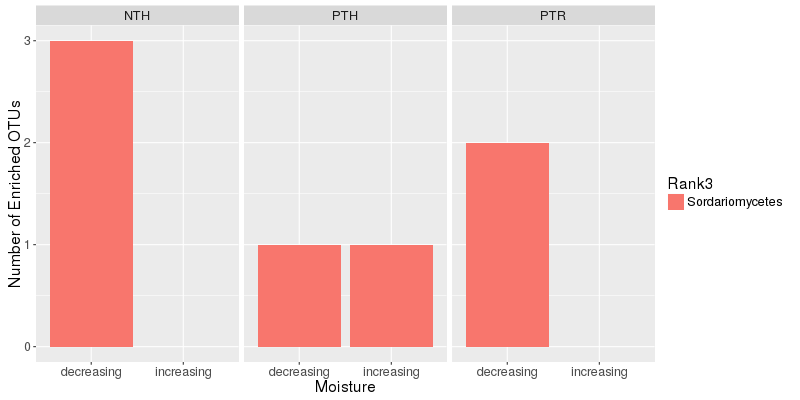

In [20]:
%%R -w 800 -h 400
p = ggplot(data = resp, aes(x = Moisture, y = resp, fill = Rank3)) +
    geom_bar(stat = 'identity') + facet_wrap(~Land_Management) +
    theme(text = element_text(size=16)) + ylab("Number of Enriched OTUs") 
p

In [21]:
%%R
ggsave(filename = "data/figs/EnrichedNumoverTime.jpg", plot = p, width =12, height =6)